In [1]:
# Diagnose errors with the GPU

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
!pip install -U scikit-learn

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset
from huggingface_hub import login
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, cohen_kappa_score, brier_score_loss

DATASET_ID = "ADS509/full_experiment_labels"

MODELS = {
    "RoBERTa": "ADS509/experiment_labels_roberta_base",
    "BERTweet": "ADS509/BERTweet-large-self-labeling",
    "BERT base": "ADS509/experiment_labels_bert_base",
}

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
GPU available: True
GPU: NVIDIA A100-SXM4-40GB


In [5]:
# Hugging Face login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


# Load Test Data

In [6]:
dataset = load_dataset(DATASET_ID)

test_split = dataset["test"]
texts = list(test_split["text"])
true_preds = np.array(test_split["label"])

print(f"\nTest samples : {len(texts):,}")
unique, counts = np.unique(true_preds, return_counts=True)
print(f"Label distribution:")
for lbl, cnt in zip(unique, counts):
    print(f"  {lbl}: {cnt:,}")


Test samples : 10,558
Label distribution:
  0: 779
  1: 3,257
  2: 2,423
  3: 3,289
  4: 810


## Load Pipeline

Uses `transformers.pipeline()` which handles tokenization, batching, and inference internally.
Simplest approach — good for quick evaluation and deployment.

In [20]:
def predict_pipeline(model_id: str, texts: list, k: int=3, max_length: int=512, device: int = 0, batch_size: int = 32) -> tuple:
    """
    Run text-classification predictions using a HuggingFace pipeline.

    Returns:
        pred_ints  : list of integer class predictions aligned with dataset label IDs
        id2label   : dict mapping integer IDs -> label name strings
    """
    pipe = pipeline(
        "text-classification",
        model=model_id,
        device=device,
        truncation=True,
        padding=True,
        max_length=max_length,
        batch_size=batch_size,
    )
    id2label = pipe.model.config.id2label

    predictions = pipe(texts, top_k=k)
    return predictions, id2label

### Experiment Labels Evaluation

In [ ]:
preds, id2label = predict_pipeline(model_id="ADS509/BERTweet-large-self-labeling", texts=texts, k=5)

# Convert the integer labels into named labels for readability
true_labels = [id2label[i] for i in true_preds]

# If using top_k, this will get the top prediction label and score, otherwise remove the index slicing
top_preds = [pred[0]['label'] for pred in preds]
top_scores = [pred[0]['score'] for pred in preds]

# Get the label and scores of the next predictions.  Comment out the below if not using top_k or using top_k < 3
top2_pred = [f"{pred[1]['label']}: {pred[1]['score']}" for pred in preds]
top3_pred = [f"{pred[2]['label']}: {pred[2]['score']}" for pred in preds]

print(classification_report(true_labels, top_preds))

Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

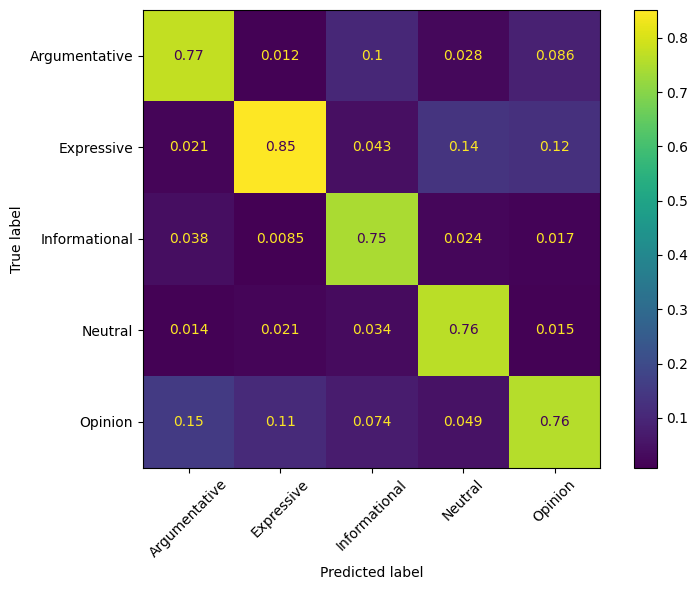

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    true_labels, top_preds, 
    xticks_rotation=45,
    normalize='pred',
    ax=ax)

plt.tight_layout()
plt.show()

In [121]:
# Measures agreement between predictions and true labels corrected for chance.  Anything above 0.5 is pretty good
cohen_kappa_score(true_labels, top_preds)

0.7176917668532257

In [122]:
# Sort labels and attach predicted outcome to each
label_order = sorted(id2label.values())
probs = np.array([
    [{p['label']: p['score'] for p in row}[lbl] for lbl in label_order]
    for row in preds
])

# Correct the floating point error that comes from each score being returned and rounded separately
probs = probs / probs.sum(axis=1, keepdims=True)

# Brier score loss measures the mean squared difference between the predicted probability and actual outcome.  Lower the better
brier_score_loss(true_labels, probs)

0.302023502338536

#### Calibration Curve
- Needs the predictions of all classes

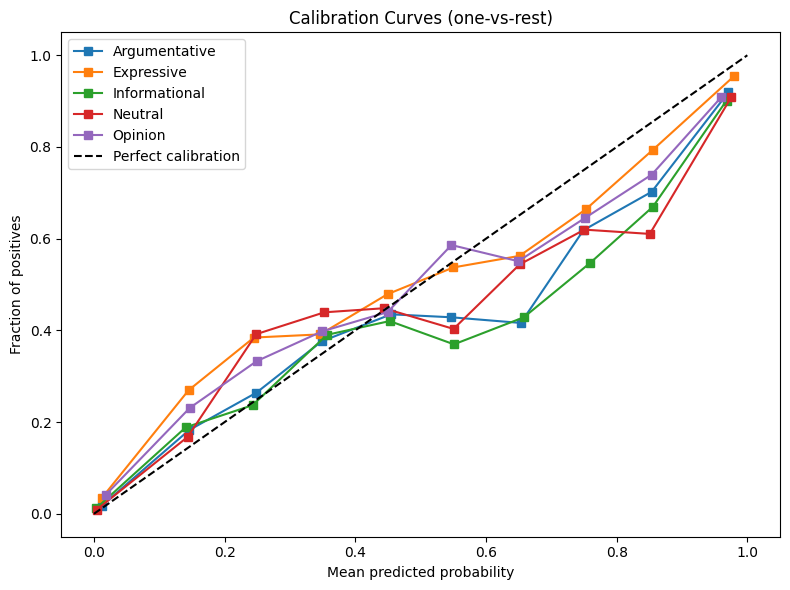

In [118]:
# Build (n_samples, n_classes) probability matrix
prob_matrix = np.zeros((len(preds), len(label_order)))
for i, pred_list in enumerate(preds):
    for pred in pred_list:
        j = label_order.index(pred["label"])
        prob_matrix[i, j] = pred["score"]

# One calibration curve per class
fig, ax = plt.subplots(figsize=(8, 6))
for j, label_name in enumerate(label_order):
    binary_true = (np.array(true_labels) == label_name).astype(int)
    frac_pos, mean_prob = calibration_curve(binary_true, prob_matrix[:, j], n_bins=10)
    ax.plot(mean_prob, frac_pos, marker="s", label=label_name)

ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend()
plt.title("Calibration Curves (one-vs-rest)")
plt.tight_layout()
plt.show()

Above the curve means the model was less confident than it should have been, below the line means the model was more confident in the prediction than it should have been. The S-shaped curve alludes to a model that's uncalibrated.  There are ways to fix this with Isotonic regression or Platt scaling, but our main issue is labeling, both in the defined scheme, and the accuracy of the true labels

#### Manual Review

In [ ]:
confidence_threshold = 0.6
df = test_split.to_pandas()

# Create column with top prediction and score, and convert true label integers to named labels
df['preds'] = top_preds
df['top_score'] = top_scores
df['label'] = df['label'].apply(lambda x: id2label[x])

# Get the predictions made with low confidence
df['low_conf'] = df['top_score'].apply(lambda x: True if x < confidence_threshold else False)

# Mark the next most likely prediction, comment out if not using top_k
df['second_place'] = top2_pred
df['third_place'] = top3_pred

# Create low confidence and overconfident subsets
low_conf = df[df['low_conf'] == True]
over_conf = df[(df['top_score'] > 0.90) & (df["preds"] != df['label'])]

In [45]:
# Explore unconfident predictions
idx = 19

print("True label: ", low_conf['label'].iloc[idx])
print("Predicted label: ", low_conf['preds'].iloc[idx])
print("Predicted score: ", low_conf['top_score'].iloc[idx], "\n")
print("2nd Predicted label: ", low_conf['second_place'].iloc[idx], "\n")
print("Text:\n\n", low_conf['text'].iloc[idx])

True label:  Argumentative
Predicted label:  Informational
Predicted score:  0.5696477890014648 

2nd Predicted label:  Argumentative: 0.4269604980945587 

Text:

 trump has signed an executive order imposing sanctions on the international criminal court: ([URL] the icc has, without a legitimate basis, asserted jurisdiction over and opened preliminary investigations concerning personnel of the united states and certain of its allies, including israel, and has further abused its power by issuing baseless arrest warrants targeting israeli prime minister benjamin netanyahu and former minister of defense yoav gallant. the icc has no jurisdiction over the united states or israel, as neither country is party to the rome statute or a member of the icc. neither country has ever recognized the icc’s jurisdiction, and both nations are thriving democracies with militaries that strictly adhere to the laws of war. the icc most certainly does have jurisdiction over crimes perpetrated in gaza, as pal

In [48]:
# Explore overconfident predictions
idx = 20

print("True label: ", over_conf['label'].iloc[idx])
print("Predicted label: ", over_conf['preds'].iloc[idx])
print("Predicted score: ", over_conf['top_score'].iloc[idx], "\n")
print("2nd Predicted label: ", over_conf['second_place'].iloc[idx], "\n")
print("Text:\n\n", over_conf['text'].iloc[idx])

True label:  Informational
Predicted label:  Opinion
Predicted score:  0.9316186308860779 

2nd Predicted label:  Informational: 0.054703664034605026 

Text:

 high treason in britain is mostly about attacks on the monarchy.


### Source Evaluation

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
import json
import pyarrow.parquet as pq
from huggingface_hub import login, HfApi, create_repo
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

# Ideally Run in Google Colab using A100 GPU for best computational performance

In [ ]:
# Step 0: Log into HuggingFace using API Token
login()

In [ ]:
# Step 1: Load the data from HuggingFace
dataset = load_dataset(
    "ADS509/final_project_data",
    data_files={
        'train': 'preprocessed_dataset/train-00000-of-00001.parquet',
        'test': 'preprocessed_dataset/test-00000-of-00001.parquet',
        'val': 'preprocessed_dataset/valid-00000-of-00001.parquet'
    })

train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
val_df = dataset['val'].to_pandas()

In [ ]:
# Step 2: Create label mappings
# Get unique sources
unique_sources = sorted(train_df['label'].unique())

# Create mappings with PROPER conversion from numpy to Python types
label2id = {str(label): int(idx) for idx, label in enumerate(unique_sources)}
id2label = {int(idx): str(label) for idx, label in enumerate(unique_sources)}

print(f"Sources: {unique_sources}")
print(f"Label mappings: {label2id}")
print(f"ID mappings: {id2label}")

# Verify types are correct
print(f"\nType check:")
print(f"label2id key type: {type(list(label2id.keys())[0])}")
print(f"label2id value type: {type(list(label2id.values())[0])}")
print(f"id2label key type: {type(list(id2label.keys())[0])}")
print(f"id2label value type: {type(list(id2label.values())[0])}")

In [ ]:
# Step 3: Initialize model and tokenizer
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

In [ ]:
# Step 4: Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=False,
        max_length=128
    )

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

In [ ]:
# Step 5: Define metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro')
    }

In [ ]:
# Step 6: Training arguments (OPTIMIZED FOR A100)
training_args = TrainingArguments(
    output_dir="./source_classifier_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,  # Increased for A100
    per_device_eval_batch_size=64,   # Increased for A100
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,  # Mixed precision for A100
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
)

In [ ]:
# Step 7: Initialize Trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Step 8: Train
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
trainer.train()

# Step 9: Evaluate on test set
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Overall metrics
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(test_df['label'], preds):.4f}")
print(f"F1 (weighted): {f1_score(test_df['label'], preds, average='weighted'):.4f}")
print(f"F1 (macro): {f1_score(test_df['label'], preds, average='macro'):.4f}")

# Detailed classification report
print("\nClassification Report:")
target_names = [id2label[i] for i in sorted(id2label.keys())]
print(classification_report(test_df['label'], preds, target_names=target_names))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['label'], preds)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_test.png', dpi=150)
print("Confusion matrix saved as 'confusion_matrix_test.png'")
plt.show()

In [ ]:
# Get confusion matrix
cm = confusion_matrix(test_df['label'], preds)

# Convert to percentages (row-wise - divides each row by its sum)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentage of True Labels)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_percentage.png', dpi=150)
plt.show()